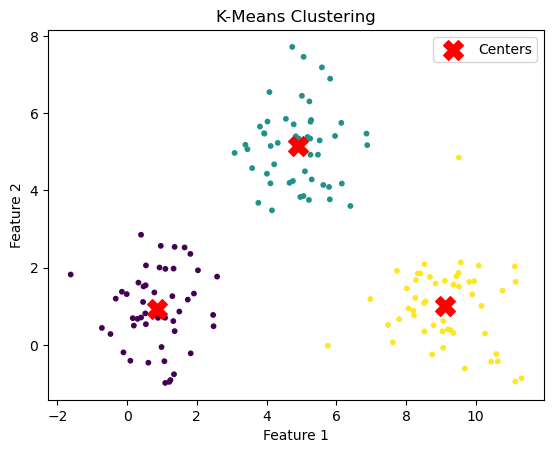

In [2]:


def kmeans(data, k, num_iterations=100, tol=1e-4):
    """
    Implémentation de l'algorithme des k-moyennes.
    """
    num_samples, num_features = data.shape

    # Initialisation aléatoire des centres
    centers = data[np.random.choice(num_samples, k, replace=False)]

    for iteration in range(num_iterations):
        # Attribution des points aux clusters les plus proches
        distances = np.linalg.norm(data[:, np.newaxis] - centers, axis=2)
        labels = np.argmin(distances, axis=1)

        # Mise à jour des centres
        new_centers = np.array([data[labels == i].mean(axis=0) for i in range(k)])

        # Critère d'arrêt : tolérance
        if np.linalg.norm(new_centers - centers) < tol:
            break

        # Mise à jour des centres
        centers = new_centers

    return centers, labels

# Générer des données pour l'exemple
np.random.seed(42)
data = np.concatenate([np.random.normal(loc=[1, 1], size=(50, 2)),
                       np.random.normal(loc=[5, 5], size=(50, 2)),
                       np.random.normal(loc=[9, 1], size=(50, 2))])

# Nombre de clusters (k)
num_clusters = 3

# Appliquer l'algorithme des k-moyennes
centers, labels = kmeans(data, num_clusters)

# Afficher les résultats
plt.scatter(data[:, 0], data[:, 1], c=labels, s=10, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Centers')
plt.title("K-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

(150,)
(150,)


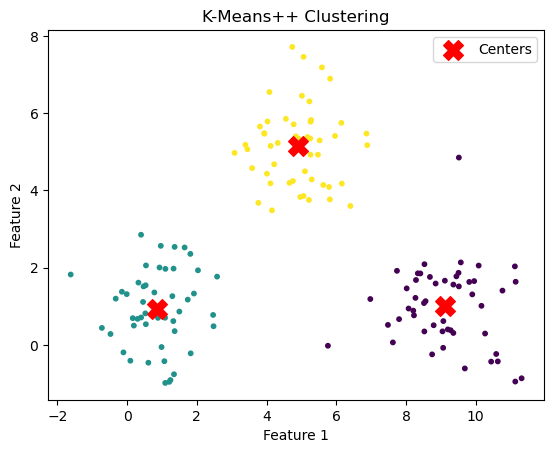

In [36]:
def kmeans_plusplus(data, k, num_iterations=100, tol=1e-4):
    """
    Implémentation de l'algorithme des k-moyennes++ avec initialisation intelligente.
    """
    num_samples, num_features = data.shape

    # Initialisation du premier centroïde aléatoirement
    centers_index=np.random.choice(num_samples)
    center =data[centers_index]
    centers=[center]
    distances=[]
    for _ in range(1, k):
        # Exclure les centres déjà choisis de l'ensemble de données
        data_without_centers = np.delete(data, centers_index, axis=0)

        # Calcul des distances quadratiques des points par rapport aux centroïdes existants
        distances = np.linalg.norm(data - center, axis=1)**2

        # Calcul des probabilités de sélection des nouveaux centroïdes
        probabilities = distances/ np.sum(distances)
        print(probabilities.shape)
        # Choix du prochain centroïde avec la probabilité donnée
        centers_index=np.random.choice(num_samples, p=probabilities.squeeze())
        center = data[centers_index]

        centers.append(center)
    # Convertir les centroïdes en array numpy
    centers = np.array(centers)

    for iteration in range(num_iterations):
        # Attribution des points aux clusters les plus proches
        distances = np.linalg.norm(data[:, np.newaxis] - centers, axis=2)
        labels = np.argmin(distances, axis=1)

        # Mise à jour des centres
        new_centers = np.array([data[labels == i].mean(axis=0) for i in range(k)])

        # Critère d'arrêt : tolérance
        if np.linalg.norm(new_centers - centers) < tol:
            break

        # Mise à jour des centres
        centers = new_centers

    return centers, labels

# Générer des données pour l'exemple
np.random.seed(42)
data = np.concatenate([np.random.normal(loc=[1, 1], size=(50, 2)),
                       np.random.normal(loc=[5, 5], size=(50, 2)),
                       np.random.normal(loc=[9, 1], size=(50, 2))])

# Nombre de clusters (k)
num_clusters = 3

# Appliquer l'algorithme des k-moyennes++ avec initialisation intelligente
centers, labels = kmeans_plusplus(data, num_clusters)

# Afficher les résultats
plt.scatter(data[:, 0], data[:, 1], c=labels, s=10, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Centers')
plt.title("K-Means++ Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [70]:
import pickle

# Charger les données depuis le fichier .pkl
with open('half-moons.pckl', 'rb') as file:
    data_all = pickle.load(file)
data=np.concatenate((np.array(data_all[0]),np.array(data_all[2])))
print(data.shape)

(271, 2)


C:\Users\Moadh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Moadh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


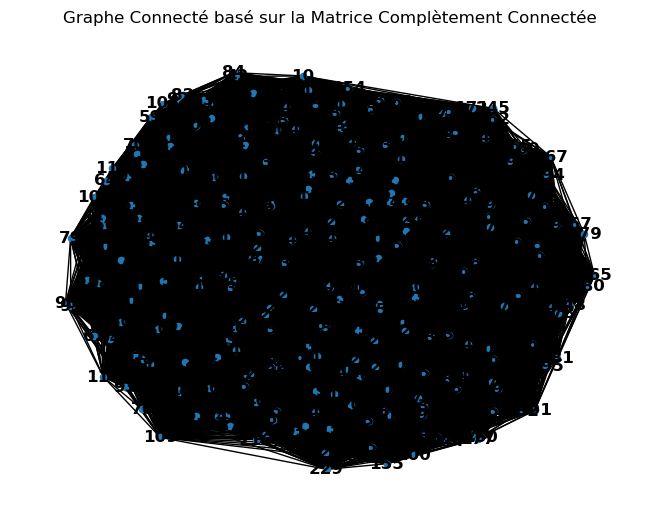

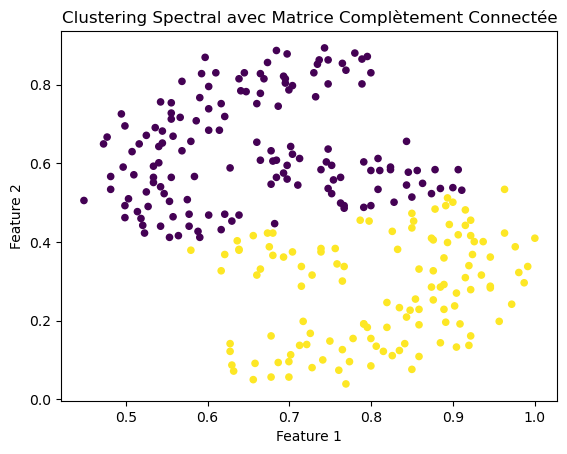

In [93]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import networkx as nx



def clustspec(W, k):
    """
    Implémentation de la technique de clustering spectral.

    Parameters:
    - W : matrice p x p de similarité
    - k : nombre de clusters cherchés

    Returns:
    - labels : étiquettes de clusters attribuées par l'algorithme de clustering spectral
    """
    # Construire la matrice Laplacienne normalisée
    D_sqrt_inv = np.diag(1 / np.sqrt(np.sum(W, axis=1)))
    L_norm = np.eye(W.shape[0]) - D_sqrt_inv @ W @ D_sqrt_inv

    # Calculer les vecteurs propres et les k plus petits vecteurs propres
    _, eigenvectors = np.linalg.eigh(L_norm)
    k_smallest_eigenvectors = eigenvectors[:, :k]

    # Normaliser les lignes des vecteurs propres
    k_smallest_eigenvectors = normalize(k_smallest_eigenvectors, norm='l2', axis=1)

    # Appliquer KMeans sur les vecteurs propres normalisés
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(k_smallest_eigenvectors)

    return labels

def adjfullconn(X, sim, sig2=1):
    """
    Construire la matrice d'adjacence complètement connectée.

    Parameters:
    - X : données
    - sim : fonction de similarité
    - sig2 : paramètre de largeur du noyau gaussien

    Returns:
    - W : matrice d'adjacence complètement connectée
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    for i in range(n):
        for j in range(i+1, n):
            W[i, j] = sim(X[i], X[j], sig2)
            W[j, i] = W[i, j]

    return W

def adjepsneigh(X, eps, sim, weighted=True ,sig2=1):
    """
    Construire la matrice d'adjacence epsilon-voisinage.

    Parameters:
    - X : données
    - eps : seuil de similarité
    - weighted : indique si le graphe est pondéré
    - sim : fonction de similarité
    - sig2 : paramètre de largeur du noyau gaussien

    Returns:
    - W : matrice d'adjacence epsilon-voisinage
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    for i in range(n):
        for j in range(i+1, n):
            similarity = sim(X[i], X[j], sig2)
            if similarity >= eps:
                W[i, j] = similarity
                W[j, i] = similarity

    return W if weighted else np.where(W > 0, 1, 0)

def adjknn(X, k, sim, sig2=1):
    """
    Construire la matrice d'adjacence des k voisins les plus proches.

    Parameters:
    - X : données
    - k : nombre de voisins
    - sim : fonction de similarité
    - sig2 : paramètre de largeur du noyau gaussien

    Returns:
    - W : matrice d'adjacence des k voisins les plus proches
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    for i in range(n):
        indices = np.argsort([sim(X[i], X[j], sig2) for j in range(n)])[-(k+1):-1]
        for j in indices:
            W[i, j] = sim(X[i], X[j], sig2)
            W[j, i] = W[i, j]

    return W

def adjmutknn(X, k, sim, sig2=1):
    """
    Construire la matrice d'adjacence des k voisins mutuellement les plus proches.

    Parameters:
    - X : données
    - k : nombre de voisins
    - sim : fonction de similarité
    - sig2 : paramètre de largeur du noyau gaussien

    Returns:
    - W : matrice d'adjacence des k voisins mutuellement les plus proches
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    for i in range(n):
        indices_i = np.argsort([sim(X[i], X[j], sig2) for j in range(n)])[-(k+1):-1]
        for j in indices_i:
            indices_j = np.argsort([sim(X[j], X[l], sig2) for l in range(n)])[-(k+1):-1]
            if i in indices_j:
                W[i, j] = sim(X[i], X[j], sig2)
                W[j, i] = W[i, j]

    return W

def simgauss(x1, x2, sig2=1):
    """
    Fonction de similarité gaussienne.

    Parameters:
    - x1, x2 : deux points
    - sig2 : paramètre de largeur du noyau gaussien

    Returns:
    - Similarité entre x1 et x2
    """
    return np.exp(-np.linalg.norm(x1 - x2)**2 / (2 * sig2))



# Construire la matrice d'adjacence complètement connectée
W_fullconn = adjfullconn(data, simgauss, sig2=0.1)

# Créer un graphe à partir de la matrice d'adjacence
G = nx.Graph(W_fullconn)
# Appliquer le clustering spectral
k_clusters = 2
labels = clustspec(W_fullconn, k_clusters)
# Afficher le graphe
plt.figure(1)
pos = nx.spring_layout(G)  # Positionnement des nœuds
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=20)
plt.title("Graphe Connecté basé sur la Matrice Complètement Connectée")
# Afficher les résultats
plt.figure(2)
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=20)
plt.title("Clustering Spectral avec Matrice Complètement Connectée")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

C:\Users\Moadh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Moadh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


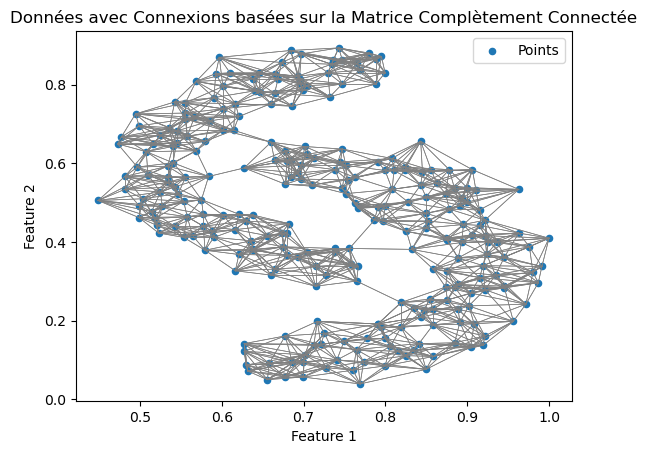

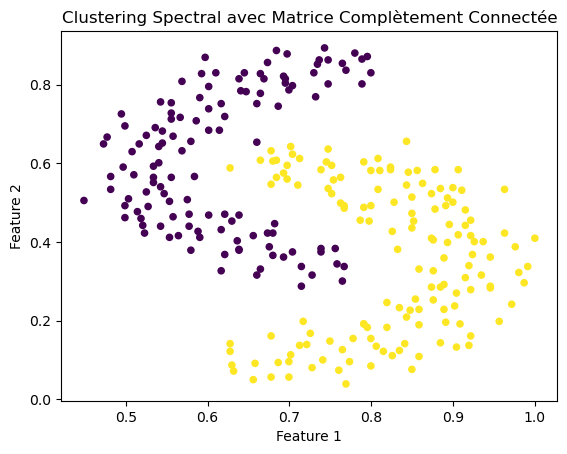

In [84]:


# Construire la matrice d'adjacence complètement connectée
W_knn = adjknn(data,10, simgauss, sig2=0.1)

# Créer un graphe à partir de la matrice d'adjacence
G = nx.Graph(W_knn)
# Appliquer le clustering spectral
k_clusters = 2
labels = clustspec(W_knn, k_clusters)
# Afficher le graphe

connected_pairs = np.column_stack(np.where(W_knn > 0))

# Tracer les données avec les connexions
plt.figure(1)
plt.scatter(data[:, 0], data[:, 1], s=20, label='Points')

for pair in connected_pairs:
    plt.plot(data[pair, 0], data[pair, 1], color='gray', linestyle='-', linewidth=0.5)

plt.title("Données avec Connexions basées sur la Matrice Complètement Connectée")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()
# Afficher les résultats
plt.figure(2)
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=20)
plt.title("Clustering Spectral avec Matrice Complètement Connectée")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

C:\Users\Moadh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Moadh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


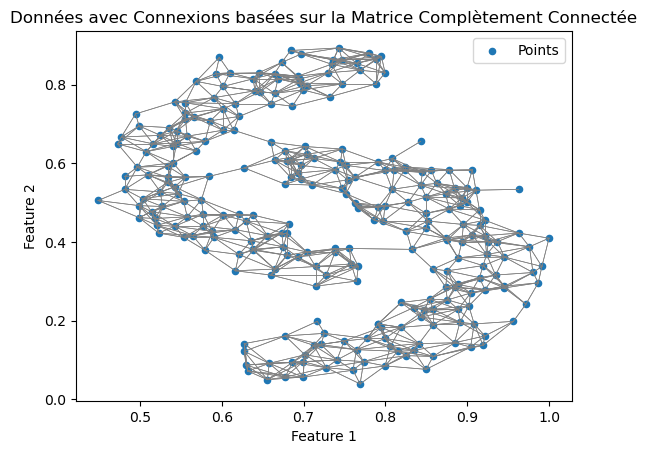

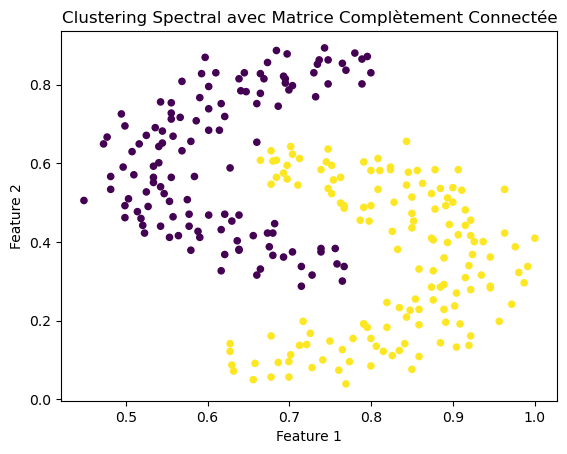

In [89]:

# Construire la matrice d'adjacence complètement connectée
W_mutknn = adjmutknn(data,10, simgauss, sig2=0.1)

# Créer un graphe à partir de la matrice d'adjacence
G = nx.Graph(W_mutknn)
# Appliquer le clustering spectral
k_clusters = 2
labels = clustspec(W_mutknn, k_clusters)

connected_pairs = np.column_stack(np.where(W_mutknn > 0))

# Afficher le graphe
plt.figure(1)

# Tracer les données avec les connexions
plt.scatter(data[:, 0], data[:, 1], s=20, label='Points')

for pair in connected_pairs:
    plt.plot(data[pair, 0], data[pair, 1], color='gray', linestyle='-', linewidth=0.5)

plt.title("Données avec Connexions basées sur la Matrice Complètement Connectée")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()
# Afficher les résultats
plt.figure(2)
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=20)
plt.title("Clustering Spectral avec Matrice Complètement Connectée")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

C:\Users\Moadh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Moadh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


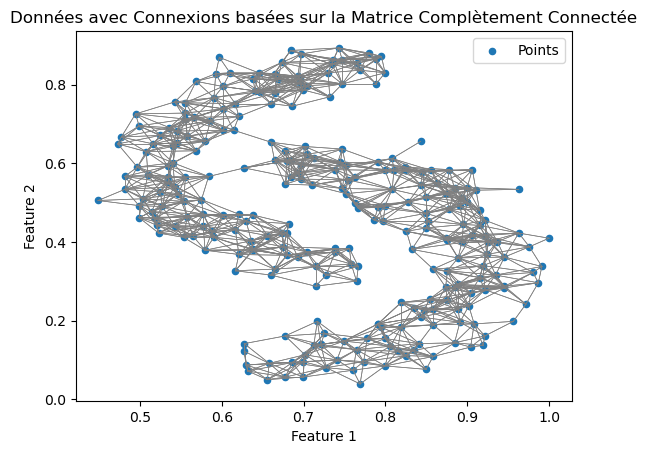

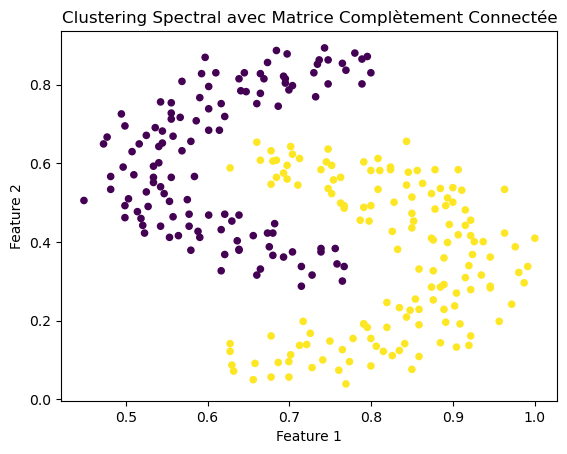

In [97]:
# Construire la matrice d'adjacence complètement connectée
W_epsneigh = adjepsneigh(data,0.98, simgauss, sig2=0.1)

# Créer un graphe à partir de la matrice d'adjacence
G = nx.Graph(W_epsneigh)
# Appliquer le clustering spectral
k_clusters = 2
labels = clustspec(W_epsneigh, k_clusters)
connected_pairs = np.column_stack(np.where(W_epsneigh > 0))

# Afficher le graphe
plt.figure(1)

# Tracer les données avec les connexions
plt.scatter(data[:, 0], data[:, 1], s=20, label='Points')

for pair in connected_pairs:
    plt.plot(data[pair, 0], data[pair, 1], color='gray', linestyle='-', linewidth=0.5)

plt.title("Données avec Connexions basées sur la Matrice Complètement Connectée")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()
# Afficher les résultats
plt.figure(2)
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=20)
plt.title("Clustering Spectral avec Matrice Complètement Connectée")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()